<a href="https://colab.research.google.com/github/TAUforPython/fuzzy/blob/main/example%20fuzzy%20timeseries%20forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Forecasting the value for Year 1992
Actual (Real) Value for 1992: 18876
Training data spans from 1971 to 1991

Step 1: Universe of Discourse U = [13000, 20000]

Step 2: Partitioned U into 7 intervals of length 1000.00

Step 3: Defined 7 Fuzzy Sets (Triangular Membership Functions)

Step 4: Fuzzified Training Data (first 5 and last 5 points)
  Year 1971: 13055 -> A1
  Year 1972: 13563 -> A1
  Year 1973: 13867 -> A1
  Year 1974: 14696 -> A2
  Year 1975: 15460 -> A3
  Year 1987: 16859 -> A4
  Year 1988: 18150 -> A6
  Year 1989: 18970 -> A6
  Year 1990: 19328 -> A7
  Year 1991: 19337 -> A7

Step 5: Fuzzy Logical Relationship Groups (first few)
  A1 -> A1, A1, A2
  A2 -> A3
  A3 -> A3, A3, A3, A4, A3, A3, A3, A3, A4
  A4 -> A4, A4, A3, A6
  A6 -> A6, A7
  ... (showing first 5 groups)

Step 6: Forecasting for Year 1992 based on Year 1991 state (A7)
  -> Fuzzy Forecast using Rule 2 (One-to-One): A7 -> A7
Fuzzy Forecasted Value for 1992: 19500.00

--- Method 2: Linear Regression Forecasting --

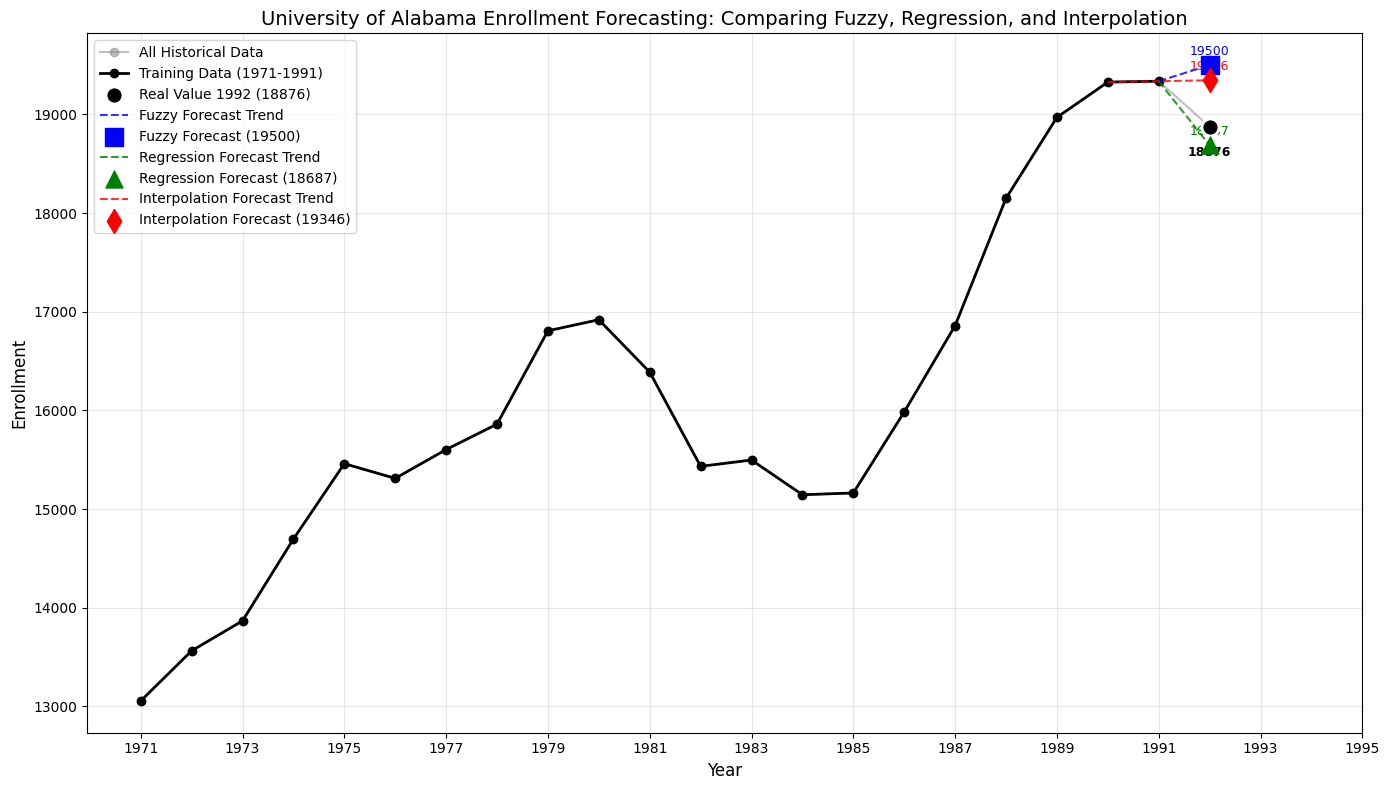


--- Summary of Forecasting Methods for 1992 ---
1. Fuzzy Time Series:
   - Based on linguistic terms and fuzzy logic relationships from training data.
   - Forecast: 19500.00 (if successful)
   - MAPE: 3.31%

2. Linear Regression:
   - Fits a straight line to all training data points.
   - Assumes a linear trend over time.
   - Forecast: 18687.22
   - MAPE: 1.00%

3. Simple Interpolation (Linear Extrapolation):
   - Uses only the last two training data points to estimate the trend.
   - Extends the line formed by the last two points.
   - Forecast: 19346.00
   - MAPE: 2.49%

Actual Value for 1992: 18876

Best performing method for 1992 (lowest MAPE): Linear Regression


In [8]:
# ---
# title: "Fuzzy Time Series Forecasting with Comparisons - Real Data Example"
# author: "Assistant (Based on Tsaur, 2012)"
# date: "2024-05-21"
# output: html_document
# ---

# This notebook demonstrates the basic concept of Fuzzy Time Series forecasting
# based on the methodology described in the paper:
# Tsaur, R.-C. (2012). A fuzzy time series-Markov chain model with an application
# to forecast the exchange rate between the Taiwan and US dollar.
# International Journal of Innovative Computing, Information and Control, 8(7(B)), 4931–4942.

# The focus is on implementing the core Fuzzy Time Series steps (Steps 1-6 from Section 2)
# using a simple example. The Markov chain extension (Section 3) is not included here.
# It also compares the Fuzzy Time Series forecast with Linear Regression and Simple Interpolation.
# This version uses the last data point as the "real" value to forecast and compares methods.

# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error

# --- Example: University of Alabama Enrollment Data (1971-1992) ---
# Using the data from Table 1 of the paper for demonstration.
# We will pretend the last data point (1992) is unknown and forecast it.

# Full historical time series data (Years 1971-1992)
full_historical_data = np.array([
    13055, 13563, 13867, 14696, 15460, 15311, 15603, 15861, # 1971-1978
    16807, 16919, 16388, 15433, 15497, 15145, 15163, 15984, # 1979-1986
    16859, 18150, 18970, 19328, 19337, 18876              # 1987-1992
])

# --- Setup for Forecasting the Last Point ---
# We will use data from 1971 to 1991 to forecast the 1992 value.
# The "real" value for 1992 is 18876.
training_data = full_historical_data[:-1] # Data from 1971 to 1991
real_value_1992 = full_historical_data[-1] # Actual value for 1992
training_years = np.arange(1971, 1971 + len(training_data))
forecast_year = 1992

print(f"Forecasting the value for Year {forecast_year}")
print(f"Actual (Real) Value for {forecast_year}: {real_value_1992}")
print(f"Training data spans from {training_years[0]} to {training_years[-1]}")

# --- Step 1: Define the Universe of Discourse (U) ---
# Define U based on the training data (1971-1991), following the paper's approach.
D_min = np.min(training_data)
D_max = np.max(training_data)
D1 = 55   # As per the paper's example for this dataset
D2 = 663  # As per the paper's example for this dataset
U_min = D_min - D1
U_max = D_max + D2
print(f"\nStep 1: Universe of Discourse U = [{U_min}, {U_max}]")

# --- Step 2: Partition the Universe of Discourse (U) into Equal Intervals ---
n_intervals = 7 # As per the paper's example
interval_length = (U_max - U_min) / n_intervals
intervals = []
for i in range(n_intervals):
    start = U_min + i * interval_length
    end = U_min + (i + 1) * interval_length
    intervals.append((start, end))
print(f"\nStep 2: Partitioned U into {n_intervals} intervals of length {interval_length:.2f}")

# --- Step 3: Define Fuzzy Sets on the Universe of Discourse (U) ---
def define_triangular_membership_functions(intervals):
    """Defines triangular membership functions for fuzzy sets."""
    fuzzy_sets = {}
    n = len(intervals)
    for i in range(n):
        center = (intervals[i][0] + intervals[i][1]) / 2
        if i == 0:
            left_base = intervals[i][0]
        else:
            left_base = (intervals[i-1][0] + intervals[i-1][1]) / 2
        if i == n - 1:
            right_base = intervals[i][1]
        else:
            right_base = (intervals[i+1][0] + intervals[i+1][1]) / 2
        fuzzy_sets[f"A{i+1}"] = {
            'center': center,
            'left_base': left_base,
            'right_base': right_base
        }
    return fuzzy_sets

def membership_degree(value, fuzzy_set_params):
    """Calculates the membership degree of a value in a fuzzy set."""
    center = fuzzy_set_params['center']
    left_base = fuzzy_set_params['left_base']
    right_base = fuzzy_set_params['right_base']
    if value <= left_base or value >= right_base:
        return 0.0
    elif left_base < value <= center:
        return (value - left_base) / (center - left_base)
    elif center < value < right_base:
        return (right_base - value) / (right_base - center)
    elif value == center:
        return 1.0
    else:
        return 0.0

fuzzy_sets = define_triangular_membership_functions(intervals)
print(f"\nStep 3: Defined {n_intervals} Fuzzy Sets (Triangular Membership Functions)")

# --- Step 4: Fuzzify the Training Data ---
def fuzzify_data_point(data_point, fuzzy_sets, intervals):
    """Assigns a crisp data point to a fuzzy set."""
    max_membership = -1
    best_set = None
    for set_name, params in fuzzy_sets.items():
        degree = membership_degree(data_point, params)
        if degree > max_membership:
            max_membership = degree
            best_set = set_name
    if max_membership == 0: # Fallback if no membership > 0
         for i, (start, end) in enumerate(intervals):
             if start <= data_point < end or (i == len(intervals) - 1 and data_point == end):
                 best_set = f"A{i+1}"
                 break
    return best_set

fuzzified_training_data = [fuzzify_data_point(data_point, fuzzy_sets, intervals) for data_point in training_data]
print(f"\nStep 4: Fuzzified Training Data (first 5 and last 5 points)")
for i in [0, 1, 2, 3, 4, -5, -4, -3, -2, -1]:
    year = training_years[i]
    data_point = training_data[i]
    fuzzy_set = fuzzified_training_data[i]
    print(f"  Year {year}: {data_point} -> {fuzzy_set}")

# --- Step 5: Determine Fuzzy Logical Relationship Groups ---
def determine_relationships(fuzzified_data):
    """Determines fuzzy logical relationships."""
    relationships = {}
    for i in range(1, len(fuzzified_data)):
        previous_state = fuzzified_data[i-1]
        current_state = fuzzified_data[i]
        if previous_state in relationships:
            relationships[previous_state].append(current_state)
        else:
            relationships[previous_state] = [current_state]
    return relationships

flr_groups = determine_relationships(fuzzified_training_data)
print(f"\nStep 5: Fuzzy Logical Relationship Groups (first few)")
count = 0
for from_state, to_states in flr_groups.items():
    print(f"  {from_state} -> {', '.join(to_states)}")
    count += 1
    if count >= 5: # Limiting output for readability
        print("  ... (showing first 5 groups)")
        break

# --- Step 6: Calculate the Forecasted Output using Fuzzy Time Series ---
def calculate_midpoints(intervals):
    """Calculates the midpoint of each interval."""
    return [(start + end) / 2 for start, end in intervals]

def forecast_next_value(current_fuzzy_state, flr_groups, midpoints, fuzzy_set_names):
    """Forecasts the next value based on fuzzy logical relationships."""
    try:
        current_index = fuzzy_set_names.index(current_fuzzy_state)
    except ValueError:
        print(f"Warning: Current state {current_fuzzy_state} not found.")
        return None

    if current_fuzzy_state in flr_groups:
        next_states = flr_groups[current_fuzzy_state]
        if len(next_states) == 1:
            # Rule 2: One-to-one
            next_state = next_states[0]
            try:
                next_index = fuzzy_set_names.index(next_state)
                forecast = midpoints[next_index]
                print(f"  -> Fuzzy Forecast using Rule 2 (One-to-One): {current_fuzzy_state} -> {next_state}")
            except ValueError:
                print(f"Warning: Next state {next_state} not found.")
                forecast = None
        else:
            # Rule 3: One-to-many
            print(f"  -> Fuzzy Forecast using Rule 3 (One-to-Many): {current_fuzzy_state} -> {', '.join(next_states)}")
            sum_midpoints = 0
            count = 0
            for state in next_states:
                try:
                    index = fuzzy_set_names.index(state)
                    sum_midpoints += midpoints[index]
                    count += 1
                except ValueError:
                    print(f"Warning: State {state} not found for averaging.")
            if count > 0:
                forecast = sum_midpoints / count
            else:
                forecast = None
    else:
        # Rule 1: No relationship (empty group)
        print(f"  -> Fuzzy Forecast using Rule 1 (No Relationship): {current_fuzzy_state} -> Ø")
        forecast = midpoints[current_index]

    return forecast

# Perform Fuzzy Forecasting for 1992
midpoints = calculate_midpoints(intervals)
fuzzy_set_names = [f"A{i+1}" for i in range(n_intervals)]
current_fuzzy_value_1991 = fuzzified_training_data[-1] # A6
print(f"\nStep 6: Forecasting for Year {forecast_year} based on Year {forecast_year-1} state ({current_fuzzy_value_1991})")
forecasted_value_1992_fuzzy = forecast_next_value(current_fuzzy_value_1991, flr_groups, midpoints, fuzzy_set_names)

if forecasted_value_1992_fuzzy is not None:
    print(f"Fuzzy Forecasted Value for {forecast_year}: {forecasted_value_1992_fuzzy:.2f}")
else:
    print("Fuzzy Forecasting failed.")

# --- Method 2: Linear Regression Forecasting ---
print(f"\n--- Method 2: Linear Regression Forecasting ---")
X_train = np.arange(len(training_data)).reshape(-1, 1)
y_train = training_data
model = LinearRegression()
model.fit(X_train, y_train)
X_forecast = np.array([[len(training_data)]]) # Index for 1992
forecasted_value_1992_regression = model.predict(X_forecast)[0]
print(f"Regression Forecasted Value for {forecast_year}: {forecasted_value_1992_regression:.2f}")

# --- Method 3: Simple Interpolation Forecasting ---
print(f"\n--- Method 3: Simple Interpolation Forecasting ---")
y_n_minus_1 = training_data[-2] # 1990 value
y_n = training_data[-1]         # 1991 value
forecasted_value_1992_interpolation = y_n + (y_n - y_n_minus_1)
print(f"Interpolation Forecasted Value for {forecast_year}: {forecasted_value_1992_interpolation:.2f}")

# --- Calculate MAPE for Each Method ---
# Note: MAPE is typically for out-of-sample forecasts. Here we compare forecasts of the last point.
def calculate_single_mape(real, forecast):
    """Calculate MAPE for a single forecast point."""
    return abs((real - forecast) / real) * 100

mape_fuzzy = calculate_single_mape(real_value_1992, forecasted_value_1992_fuzzy)
mape_regression = calculate_single_mape(real_value_1992, forecasted_value_1992_regression)
mape_interpolation = calculate_single_mape(real_value_1992, forecasted_value_1992_interpolation)

print(f"\n--- Forecast Accuracy (MAPE) for Year {forecast_year} ---")
print(f"Fuzzy Time Series MAPE: {mape_fuzzy:.2f}%")
print(f"Linear Regression MAPE: {mape_regression:.2f}%")
print(f"Simple Interpolation MAPE: {mape_interpolation:.2f}%")

# --- Visualization: Final Comparison Plot ---
plt.figure(figsize=(14, 8))

# Plot all historical data
all_years = np.arange(1971, 1971 + len(full_historical_data))
plt.plot(all_years, full_historical_data, marker='o', linestyle='-', color='grey', alpha=0.5, label='All Historical Data')

# Highlight training data
plt.plot(training_years, training_data, marker='o', linestyle='-', color='black', label='Training Data (1971-1991)', linewidth=2)

# Mark the real value for 1992
plt.scatter(forecast_year, real_value_1992, color='black', marker='o', s=150, label=f'Real Value {forecast_year} ({real_value_1992})', zorder=5, edgecolors='white', linewidths=2)

# Plot forecasted values
# Fuzzy Forecast
if forecasted_value_1992_fuzzy is not None:
    plt.plot([training_years[-1], forecast_year], [training_data[-1], forecasted_value_1992_fuzzy],
             linestyle='--', color='blue', alpha=0.8, label='Fuzzy Forecast Trend')
    plt.scatter(forecast_year, forecasted_value_1992_fuzzy, color='blue', marker='s', s=150,
                label=f'Fuzzy Forecast ({forecasted_value_1992_fuzzy:.0f})', zorder=5)

# Regression Forecast
plt.plot([training_years[-1], forecast_year], [training_data[-1], forecasted_value_1992_regression],
         linestyle='--', color='green', alpha=0.8, label='Regression Forecast Trend')
plt.scatter(forecast_year, forecasted_value_1992_regression, color='green', marker='^', s=150,
            label=f'Regression Forecast ({forecasted_value_1992_regression:.0f})', zorder=5)

# Interpolation Forecast
plt.plot([training_years[-2], training_years[-1], forecast_year],
         [y_n_minus_1, y_n, forecasted_value_1992_interpolation],
         linestyle='--', color='red', alpha=0.8, label='Interpolation Forecast Trend')
plt.scatter(forecast_year, forecasted_value_1992_interpolation, color='red', marker='d', s=150,
            label=f'Interpolation Forecast ({forecasted_value_1992_interpolation:.0f})', zorder=5)

# Add value labels for forecasts
if forecasted_value_1992_fuzzy is not None:
    plt.text(forecast_year, forecasted_value_1992_fuzzy + 100, f'{forecasted_value_1992_fuzzy:.0f}',
             color='blue', ha='center', fontsize=9)
plt.text(forecast_year, forecasted_value_1992_regression + 100, f'{forecasted_value_1992_regression:.0f}',
         color='green', ha='center', fontsize=9)
plt.text(forecast_year, forecasted_value_1992_interpolation + 100, f'{forecasted_value_1992_interpolation:.0f}',
         color='red', ha='center', fontsize=9)
plt.text(forecast_year, real_value_1992 - 300, f'{real_value_1992}',
         color='black', ha='center', fontsize=9, weight='bold')

plt.xlabel('Year', fontsize=12)
plt.ylabel('Enrollment', fontsize=12)
plt.title('University of Alabama Enrollment Forecasting: Comparing Fuzzy, Regression, and Interpolation', fontsize=14)
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.xticks(np.arange(1971, 1996, 2)) # Show years
plt.tight_layout()
plt.show()

# --- Summary ---
print("\n--- Summary of Forecasting Methods for 1992 ---")
print("1. Fuzzy Time Series:")
print("   - Based on linguistic terms and fuzzy logic relationships from training data.")
print(f"   - Forecast: {forecasted_value_1992_fuzzy:.2f} (if successful)")
print(f"   - MAPE: {mape_fuzzy:.2f}%")

print("\n2. Linear Regression:")
print("   - Fits a straight line to all training data points.")
print("   - Assumes a linear trend over time.")
print(f"   - Forecast: {forecasted_value_1992_regression:.2f}")
print(f"   - MAPE: {mape_regression:.2f}%")

print("\n3. Simple Interpolation (Linear Extrapolation):")
print("   - Uses only the last two training data points to estimate the trend.")
print("   - Extends the line formed by the last two points.")
print(f"   - Forecast: {forecasted_value_1992_interpolation:.2f}")
print(f"   - MAPE: {mape_interpolation:.2f}%")

print(f"\nActual Value for {forecast_year}: {real_value_1992}")

# Determine the best method based on MAPE
mape_dict = {
    'Fuzzy Time Series': mape_fuzzy,
    'Linear Regression': mape_regression,
    'Simple Interpolation': mape_interpolation
}
best_method = min(mape_dict, key=mape_dict.get)
print(f"\nBest performing method for {forecast_year} (lowest MAPE): {best_method}")